In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [71]:
from pandas_datareader import wb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, time
from wb_api_wraper import *

In [3]:
#Names to WB names
any_to_wb = pd.read_csv("inputs/any_name_to_wb_name.csv",index_col="any",squeeze=True)

#iso3 to wb country name table
iso3_to_wb=pd.read_csv("inputs/iso3_to_wb_name.csv").set_index("iso3").squeeze()

#iso2 to iso3 table
iso2_iso3 = pd.read_csv("inputs/names_to_iso.csv", usecols=["iso2","iso3"]).drop_duplicates().set_index("iso2").squeeze() #the tables has more lines than countries to account for several ways of writing country names

In [4]:
mehdi_folder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/Mehdi/Analyse/Objectif"

In [111]:
all_rai_data = pd.DataFrame()
for myfilename in os.listdir(mehdi_folder):
    myfile = pd.read_excel(mehdi_folder+"/"+myfilename)
    myinfo = myfilename.replace(".csv",'').split("_")
    myfile["country"] = myinfo[0]
    myfile = myfile.reset_index().rename(columns={"index":"connection_order"}).set_index(["country","connection_order"])
    all_rai_data = all_rai_data.append(myfile)

In [112]:
all_rai_data.columns

Index(['Connection_Number', 'Cost_Upgrade($M)', 'Cost_upgrade', 'Country',
       'Cumu Distance', 'Cumu_People', 'Cumulative Distance',
       'Cumulative People', 'Inter_PS', 'Length_Roads', 'Linked_Net',
       'Linked_Network', 'New_People', 'People', 'People_per_km',
       'Rai_Increase(%)'],
      dtype='object')

In [114]:
all_rai_data[['Cumu_People','Cumulative People']].isnull().sum(axis=0)

Cumu_People           4578
Cumulative People    20173
dtype: int64

In [116]:
all_rai_data['Cumu_People_corrected'] = all_rai_data['Cumu_People'].fillna(all_rai_data['Cumulative People'])

In [118]:
all_rai_data.Cumu_People_corrected.isnull().sum()

0

In [119]:
tostudy = all_rai_data[["Cost_upgrade","Length_Roads","Rai_Increase(%)","Cumu_People_corrected"]]

In [120]:
last_row = tostudy.reset_index().dropna().groupby("country").apply(lambda x:x.loc[x["Rai_Increase(%)"].argmax()])

In [121]:
last_row['half_cost'] = last_row.Cost_upgrade/2

In [122]:
tostudy2 = tostudy.reset_index().merge(last_row[["country","half_cost"]],on="country",how='left')

In [123]:
tostudy3 = tostudy2.dropna().groupby("country").apply(lambda x:x.loc[(x.Cost_upgrade<x.half_cost)])

In [125]:
half_row = tostudy3.groupby(level="country").apply(lambda x:x.loc[x["Rai_Increase(%)"].argmax()])

In [126]:
last_row["country"] = last_row.country.replace(iso3_to_wb)

In [127]:
half_row["country"] = half_row.country.replace(iso3_to_wb)

In [128]:
data_folder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/transport_rai_output_data/"

In [129]:
rai = pd.DataFrame()
for scenario in ["RAI_PS","RAI_PST","RAI_PSTT"]:
    x = pd.read_excel(data_folder+"RAI_WorldPop.xlsx",sheetname=scenario)
    x["scenario"] = scenario
    rai = rai.append(x)

In [130]:
rai["country"] = rai.Country.replace(any_to_wb)
rai = rai.drop("Country",axis=1)

In [131]:
results = rai.loc[rai.scenario=="RAI_PS",:].merge(last_row,on="country",how="right").rename(columns={"Rai_Increase(%)":"new_RAI"})

In [132]:
results_half = rai.loc[rai.scenario=="RAI_PS",:].merge(half_row,on="country",how="right").rename(columns={"Rai_Increase(%)":"new_RAI"})

In [133]:
results_half["new_RAI"] = results_half.new_RAI.clip(upper = 100)

In [134]:
results["new_RAI"] = results.new_RAI.clip(upper = 100)

In [135]:
results_half["rai_increase"] = results_half.new_RAI-results_half.RAI

In [136]:
results["rai_increase"] = results.new_RAI-results.RAI

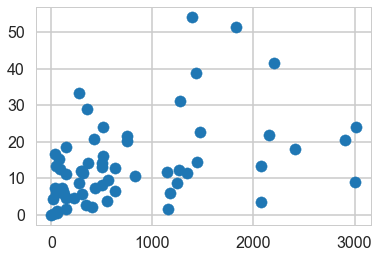

In [137]:
plt.scatter(results.Cost_upgrade,results.rai_increase)

In [138]:
results.loc[results.rai_increase>30,:]

,Pop Rural Total,Pop Rural < 2km,RAI,scenario,country,connection_order,Cost_upgrade,Length_Roads,new_RAI,Cumu_People_corrected,half_cost,rai_increase
0,3.691300e+05,2.462080e+05,66.699537,RAI_PS,Albania,227,275.474761,7.698718,100.000000,1.313550e+05,137.737381,33.300463
13,5.510400e+06,2.295713e+06,41.661453,RAI_PS,Cuba,867,1826.355713,6.153524,93.132453,2.836258e+06,913.177856,51.470999
16,6.202643e+06,3.044648e+06,49.086302,RAI_PS,Ecuador,1112,2199.658080,4.792760,90.797128,2.587174e+06,1099.829040,41.710826
22,1.042630e+07,3.170227e+06,30.406057,RAI_PS,Guatemala,973,1396.218914,2.414229,84.583526,5.648705e+06,698.109457,54.177468
32,1.305839e+07,8.973352e+06,68.717135,RAI_PS,Sri Lanka,1846,1269.902799,1.875691,100.000000,1.153421e+07,634.951400,31.282865
56,3.216184e+06,1.184565e+06,36.831394,RAI_PS,Tunisia,780,1430.028859,2.236385,75.577760,1.246155e+06,715.014429,38.746367


In [143]:
results["new_people_served"] = results["Pop Rural < 2km"]+results["Cumu_People_corrected"]
results["new_people_served"] = results["new_people_served"].clip(upper = results["Pop Rural Total"])

In [144]:
results_half["new_people_served"] = results_half["Pop Rural < 2km"]+results_half["Cumu_People_corrected"]
results_half["new_people_served"] = results_half["new_people_served"].clip(upper = results_half["Pop Rural Total"])

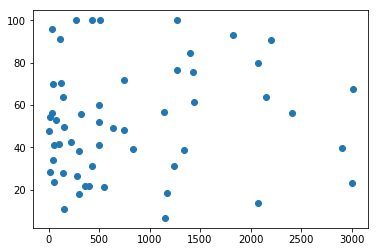

In [60]:
plt.scatter(results.Cost_upgrade,results.new_RAI)

In [62]:
results.loc[results.new_RAI>70,:]

,Pop Rural Total,Pop Rural < 2km,RAI,scenario,country,connection_order,Cost_upgrade,Length_Roads,new_RAI,rai_increase
0,3.691300e+05,2.462080e+05,66.699537,RAI_PS,Albania,227,275.474761,7.698718,100.000000,33.300463
3,9.968155e+06,6.480396e+06,65.010982,RAI_PS,Burundi,74,125.600010,4.161986,70.597481,5.586498
5,7.420280e+05,5.876550e+05,79.195799,RAI_PS,Bosnia and Herzegovina,424,425.772335,3.485810,100.000000,20.804201
12,4.340356e+05,2.464043e+05,56.770516,RAI_PS,Cape Verde,30,44.025826,1.034504,70.050985,13.280469
13,5.510400e+06,2.295713e+06,41.661453,RAI_PS,Cuba,867,1826.355713,6.153524,93.132453,51.470999
15,6.202643e+06,3.044648e+06,49.086302,RAI_PS,Ecuador,1112,2199.658080,4.792760,90.797128,41.710826
21,1.042630e+07,3.170227e+06,30.406057,RAI_PS,Guatemala,973,1396.218914,2.414229,84.583526,54.177468
23,7.975540e+05,6.690180e+05,83.883724,RAI_PS,Hungary,601,513.686598,1.336784,100.000000,16.116276
27,1.305839e+07,8.973352e+06,68.717135,RAI_PS,Sri Lanka,1846,1269.902799,1.875691,100.000000,31.282865
29,8.630600e+04,7.325400e+04,84.877065,RAI_PS,"Macedonia, FYR",42,117.453439,10.071660,91.333163,6.456098


In [63]:
results["rai_per_dollar"] = results.rai_increase/results.Cost_upgrade

In [145]:
results["dollar_per_people"] = results.Cost_upgrade/results.Cumu_People_corrected

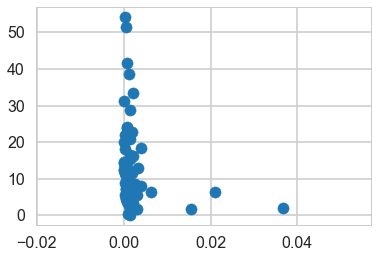

In [146]:
plt.scatter(results.loc[results.country!="Ukraine","dollar_per_people"],results.loc[results.country!="Ukraine","rai_increase"])

In [72]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

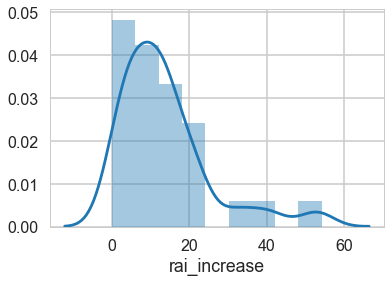

In [73]:
sns.distplot(results.rai_increase)

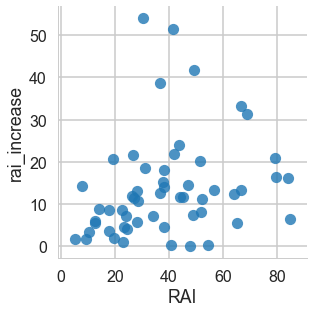

In [74]:
sns.lmplot("RAI", "rai_increase", data=results, fit_reg=False)

In [147]:
codes = pd.read_csv("C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/Mehdi/Analyse/wbccodes2014.csv")

In [148]:
codes.columns

Index(['country', 'country_name', 'wbregion', 'wbregionname', 'wbincome',
       'wbincomename', 'wblending', 'wbhipc'],
      dtype='object')

In [149]:
results["wbregionname"] = results.country.replace(codes.set_index("country_name").wbregionname) 

In [150]:
results_half["wbregionname"] = results_half.country.replace(codes.set_index("country_name").wbregionname) 

In [82]:
by_reg = results.set_index(["wbregionname","country"])[["rai_increase","Cost_upgrade"]].mean(level="wbregionname")

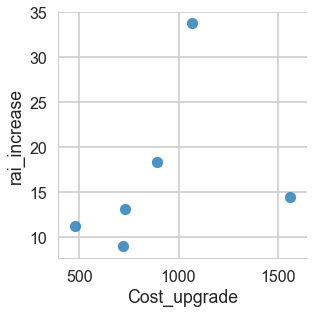

In [83]:
sns.lmplot("Cost_upgrade", "rai_increase", data=by_reg, fit_reg=False)

In [109]:
by_reg_half = results_half.set_index(["wbregionname","country"])[["rai_increase","Cost_upgrade"]].mean(level="wbregionname")

In [110]:
by_reg_half

,rai_increase,Cost_upgrade
wbregionname,,
East Asia & Pacific,9.665697,779.850757
Europe & Central Asia,11.606065,402.029521
Latin America & Caribbean,20.299321,531.416753
Middle East & North Africa,7.058861,233.736473
South Asia,15.216364,443.911279
Sub-Saharan Africa,5.827302,356.640656


In [154]:
by_reg_people = results.set_index(["wbregionname","country"])[["Pop Rural Total","new_people_served","Pop Rural < 2km"]].sum(level="wbregionname")

In [162]:
total_people = results.set_index(["wbregionname","country"])[["Pop Rural Total","new_people_served","Pop Rural < 2km"]].sum()

In [163]:
total_people[["new_people_served","Pop Rural < 2km"]].div(total_people["Pop Rural Total"],axis=0)

new_people_served    0.523218
Pop Rural < 2km      0.388733
dtype: float64

In [160]:
by_reg_people[["new_people_served","Pop Rural < 2km"]].div(by_reg_people["Pop Rural Total"],axis=0).to_csv("impact_1_percent_pop_served.csv")

In [158]:
by_reg_people_half = results_half.set_index(["wbregionname","country"])[["Pop Rural Total","new_people_served","Pop Rural < 2km"]].sum(level="wbregionname")

In [161]:
by_reg_people_half[["new_people_served","Pop Rural < 2km"]].div(by_reg_people["Pop Rural Total"],axis=0).to_csv("impact_05_percent_pop_served.csv")

In [ ]:
out = rai.set_index(["country","scenario"]).RAI.unstack("scenario")

In [5]:
road_paved_pc = get_wb_mrv('IS.ROD.PAVE.ZS',"road_paved_pc")

In [8]:
road_paved_pc.to_csv("inputs/road_paved_pc.csv")

In [6]:
#World Development Indicators
gdp_pc_pp    = get_wb_mrv('NY.GDP.PCAP.pp.kd',"gdp_pc_pp")#Gdp per capita ppp
pop          = get_wb_mrv('SP.POP.TOTL'      ,"pop")#population
#ppp_over_mer = get_wb_mrv('PA.NUS.PPPC.RF',"ppp_over_mer")#conversion factor PPP over MER
gdp_pc_cd=get_wb_mrv('ny.gdp.pcap.cd'   ,"gdp_pc_cd")#gdp per capita mer
# gap2     =get_wb_mrv('1.0.PGap.2.5usd'  ,"gap2")#poverty gap at 2$
# head2    =get_wb_mrv('SI.POV.2DAY'      ,"head2")# povety count at 2$
gini       = get_wb_mrv('SI.POV.GINI',"gini")

In [9]:
out = rai.set_index(["country","scenario"]).RAI.unstack("scenario")

In [11]:
play = out.RAI_PS

In [22]:
play.loc[(play<60)&(play>0)]

country
Afghanistan                       20.310014
Angola                            19.557927
Argentina                         43.174561
Armenia                           17.721927
Azerbaijan                        27.204838
Bangladesh                        47.032996
Belize                            26.670809
Benin                             36.090735
Bhutan                            34.188651
Bolivia                           20.502722
Botswana                          28.014343
Brazil                            35.528657
Bulgaria                          37.679667
Burkina Faso                      15.706451
Cambodia                          38.090628
Cameroon                          31.109553
Cape Verde                        56.770516
Central African Republic          22.825729
Chad                              13.924439
China                             57.370700
Colombia                          23.937524
Comoros                           24.323723
Congo, Dem. Rep.        

In [23]:
out['increase'] = out.RAI_PSTT-out.RAI_PS

In [25]:
out.loc[out.RAI_PSTT<50,:]

scenario,RAI_PS,RAI_PST,RAI_PSTT,increase
country,,,,
American Samoa,0.000000,0.000000,0.000000,0.000000
Angola,19.557927,40.896314,42.248379,22.690452
Armenia,17.721927,28.878332,29.454890,11.732963
Belarus,0.000000,0.000000,0.000000,0.000000
Central African Republic,22.825729,33.642108,40.811124,17.985395
Chad,13.924439,28.489657,35.284830,21.360391
"Congo, Rep.",12.506179,39.687739,45.960853,33.454674
Eritrea,23.286204,33.045347,34.526300,11.240095
"Iran, Islamic Rep.",20.344620,46.034194,49.292442,28.947822


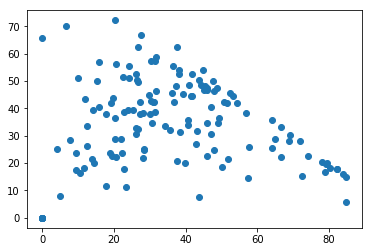

In [40]:
plt.scatter(out.RAI_PS,out.increase)

In [41]:
roads = pd.read_excel("Elco results\output_data\length_roads.xlsx")
roads["country"] = roads.Country.replace(any_to_wb)
roads = roads.fillna(0).drop("Country",axis=1)
roads = roads.set_index("country")
roads.columns.name = "road_type"
roads = roads.stack().reset_index().rename(columns={0:"km"})

In [42]:
roads

,country,road_type,km
0,Afghanistan,other,507.711221
1,Afghanistan,primary,6608.391766
2,Afghanistan,secondary,5537.112639
3,Afghanistan,tertiary,38426.022002
4,Afghanistan,track,57084.453671
5,Angola,other,343.306107
6,Angola,primary,8824.373143
7,Angola,secondary,8352.878989
8,Angola,tertiary,70977.249347
9,Angola,track,10847.372003


In [12]:
pd.read_excel(data_folder+"RAI_gpw.xlsx")

,Country,Pop Rural Total,Pop Rural < 2km,RAI
0,Afghanistan,2.493893e+07,5.628974e+06,22.571033
1,Angola,2.130044e+07,2.928206e+06,13.747162
2,Albania,1.333119e+06,7.511979e+05,56.348890
3,Argentina,2.211754e+07,5.678439e+06,25.673921
4,Armenia,1.107564e+06,2.055957e+05,18.562878
5,American Samoa,5.666631e+03,4.791430e+03,84.555167
6,Azerbaijan,5.946369e+06,1.621208e+06,27.263828
7,Burundi,8.868071e+06,5.567524e+06,62.781686
8,Benin,9.145383e+06,2.773378e+06,30.325440
9,Burkina Faso,1.692824e+07,3.029180e+06,17.894240


In [13]:
pd.read_excel(data_folder+"RAI_SSP3.xlsx")

,Country,2000,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
0,Afghanistan,17.220670,17.805654,17.074742,16.162747,15.923948,15.489007,14.880107,14.602849,14.200263,13.622287,13.313094
1,Angola,8.588595,6.010599,5.802828,5.795954,5.615336,5.600894,5.634318,5.672812,5.720083,5.738772,5.723211
2,Albania,47.844150,41.523880,41.071438,41.177265,40.778982,41.026282,40.700578,40.816159,40.619968,40.021070,39.789884
3,Argentina,33.165816,22.874945,21.467091,20.531422,19.582538,19.478369,18.519383,18.522382,19.222210,18.470014,18.474210
4,Armenia,14.309439,10.790021,10.296645,10.645945,10.826446,11.082928,11.283880,11.457051,11.546049,11.705900,11.937337
5,Azerbaijan,33.744276,31.885145,31.771467,31.299539,30.898628,30.593267,30.349441,29.927482,30.081679,29.947702,29.376865
6,Burundi,63.591196,63.727840,63.763888,63.272809,62.714234,62.242540,62.184134,62.037843,61.897960,61.736649,61.564818
7,Benin,32.359514,25.646890,25.312831,24.656292,24.093138,23.902637,23.729837,23.676495,23.428250,22.905684,22.452040
8,Burkina Faso,18.848503,15.395510,14.654477,14.450542,14.067732,13.695704,13.341559,13.250595,12.948846,12.853652,12.811999
9,Bangladesh,24.333110,44.891384,44.808046,44.792375,44.531465,44.360715,44.231430,44.094778,43.860091,43.634430,43.538115
